## 1. Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag


import string
import re

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Importing Dataset (.csv)

df_fake = pd.read_csv("./Dataset/Fake.csv")
df_true = pd.read_csv("./Dataset/True.csv")

# Creating labels for each category of fake news

df_fake["label"] = "1"
df_true["label"] = "0"


df_fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [3]:
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


### Combining both datasets into one 

In [4]:
df = pd.concat([df_fake, df_true])
df.shape

# Remove irrelevant columns
df.drop(['title', 'subject', 'date'], axis=1, inplace=True)


# Removing rows with empty text

df['text'].dropna(inplace = True)

df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [5]:

'''

Merged dataset with counts of labelled news where:
1 = fake news 
0 = true news

Total n of elemetents = 44,898

'''

df.label.value_counts(dropna = False)

1    23481
0    21417
Name: label, dtype: int64

In [6]:

# Shuffle dataframe
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index(drop=True)

df.head(10)


,text,label
0,,1
1,(Reuters) - U.S. President Donald Trump will t...,0
2,You know lies have gotten out of control when ...,1
3,BEIJING/TAIPEI (Reuters) - The United States s...,0
4,WASHINGTON/NEW YORK (Reuters) - The head of th...,0
5,HONG KONG (Reuters) - Three judges in Hong Kon...,0
6,WASHINGTON (Reuters) - Half of America’s likel...,0
7,WASHINGTON (Reuters) - Former Republican U.S. ...,0
8,Do Americans even remember the worldwide viole...,1
9,"As a side note, the last major appearance by t...",1


## 2. Dataset Preprocessing

In [7]:

'''

Preprocessing steps include: 
1. Lowercase conversion
2. Removing punctuation
3. Removing stopwords
4. Tokenization
5. Lemmatizing word tokens

'''

stopwords = set(nltk.corpus.stopwords.words('english'))
lemm = WordNetLemmatizer()

def process_text (text):
    # Removing Punctuationm
    process_text = "".join ([char for char in text if char not in string.punctuation])
    # Tokenizing Text and converting to lowercase
    process_text = re.split('\W+', text.lower())
    # Removing stopwords
    process_text = [word for word in process_text if word not in stopwords]
    # Lemmatization
    process_text = " ".join ([lemm.lemmatize(i,'v') for i in process_text])
    return process_text


In [8]:
df['cleaned'] = df['text'].apply(lambda x: process_text(x))

column_names = ["text", "cleaned", "label"]
df = df.reindex(columns=column_names)

df.head()

,text,cleaned,label
0,,,1
1,(Reuters) - U.S. President Donald Trump will t...,reuters u president donald trump target handf...,0
2,You know lies have gotten out of control when ...,know lie get control man help orchestrate iraq...,1
3,BEIJING/TAIPEI (Reuters) - The United States s...,beijing taipei reuters unite state allow deleg...,0
4,WASHINGTON/NEW YORK (Reuters) - The head of th...,washington new york reuters head u environment...,0


### Meeting Notes 9/9/2020
* split dataset 70/30 and randomise 
* find possibility to merge classifiers 
* then compare it with another dataset 

9/9/2020

## 3. Split Test/Train data

In [9]:
# The dataset shall be then split into train/test data using sklearn 
# Manipulated variable = 'cleaned' column
# Responsiding variable = 'label' ccolumn

from sklearn.model_selection import train_test_split

x = df.cleaned 
y = df.label

xTrain,xTest,yTrain,yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)


## 4. Feature Generation


### 4.1 POS Tags

* Example of tags are listed below: (From the NLTK Universal tagset)



| Tag | Meaning | English Examples |
| ------------- |:----------------:|:----------------:|
| ADJ | adjective | new, good, high, special, big, local |
| ADP | adposition  | on, of, at, with, by, into, under |
| ADV  | adverb | really, already, still, early, now |
| CONJ  | conjunction |  and, or, but, if, while, although  |
|  DET | determiner, article  | the, a, some, most, every, no, which  |
| NOUN | noun | noun year, home, costs, time, Africa   |
| NUM |numeral | twenty-four, fourth, 1991, 14:24  |
| PRT  |particle  |  at, on, out, over per, that, up, with   |
| PRON | pronoun |   he, their, her, its, my, I, us  |
| VERB | verb |  is, say, told, given, playing, would  |
| "." | punctuation | " . , ; !"  |
|X | other  | ersatz, esprit, dunno, gr8, univeristy  |


In [54]:
def pos_tag(text):
    postag = nltk.pos_tag(word_tokenize(text),tagset = 'universal')
    pos_list = list()
    for word in postag:
        pos_list.append(word[0] + "/" + word[1])
    
    final = ' '.join(pos_list)
    return final

In [55]:
xTrainPOS = xTrain.apply(pos_tag)
print (xTrainPOS.head())

36335    michigan/NOUN governor/VERB rick/ADJ snyder/NO...
12384    apparently/ADV donald/ADJ trump/NOUN america/A...
24419    member/NOUN president/NOUN trump/NOUN diversit...
24740    new/ADJ york/NOUN reuters/NOUN former/ADJ sovi...
27039    toronto/NOUN reuters/NOUN canada/VERB expel/AD...
Name: cleaned, dtype: object


In [56]:
xTestPOS = xTest.apply(pos_tag)
print (xTestPOS.head())

22216    donald/NOUN trump/NOUN media/NOUN supporters/N...
27917    brave/VERB boy/VERB sad/ADJ world/NOUN live/AD...
25007    beirut/NOUN reuters/NOUN lebanon/VERB saad/ADJ...
1377     washington/NOUN reuters/NOUN hillary/VERB clin...
32476    mainstream/ADJ media/NOUN remain/VERB transfix...
Name: cleaned, dtype: object


### 4.2 N-Grams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer(max_features=5000,ngram_range=(2,3)).fit(df.cleaned )
xTrainNgram = vect.transform(xTrain)
xTestNgram = vect.transform(xTest)

vect.get_feature_names()[:10]
print(vect.vocabulary_)

## 5. Modelling



### 5.1 Evaluation Metrics 

Several evaluation metrices shall be used:
1. Model Score (Accuracy)
1. Precision Score
1. F1- Score 
1. Recall Score

In [17]:
## Function to plot confusion matrix using matplot
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

## 5.2 Logistic Regression Modelling

### 1.TFIDF

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression


LRPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression())])

model = LRPipeline.fit(xTrain, yTrain)
yPredict = model.predict(xTest)


cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

Accuracy: 98.79%
Confusion Matrix 
 [[4242   45]
 [  64 4629]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4287
           1       0.99      0.99      0.99      4693

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Confusion matrix, without normalization


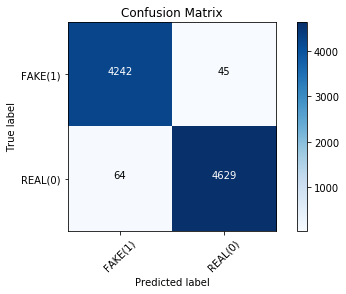

In [20]:
import itertools
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])

### 2. N-gram

In [64]:
model = LogisticRegression()
LRModel = model.fit(xTrainNgram, yTrain)

yPredict = LRModel.predict(xTestNgram)

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

Accuracy: 98.21%
Confusion Matrix 
 [[4176  111]
 [  50 4643]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4287
           1       0.98      0.99      0.98      4693

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



Confusion matrix, without normalization


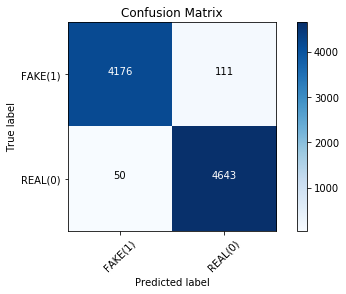

In [65]:
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])

In [74]:
# N gram model using pipeline - varies in accuracy

LRPipeline = Pipeline([('vect', CountVectorizer(ngram_range =(2,3))),
                     ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression())])

model = LRPipeline.fit(xTrain, yTrain)
yPredict = model.predict(xTest)

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))



Accuracy: 98.36%
Confusion Matrix 
 [[4238   49]
 [  98 4595]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4287
           1       0.99      0.98      0.98      4693

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



### 3. POS Tag

In [68]:
LRPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression())])

model = LRPipeline.fit(xTrainPOS,yTrain)
yPredict = model.predict(xTestPOS)

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

Accuracy: 98.04%
Confusion Matrix 
 [[4221   66]
 [ 110 4583]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4287
           1       0.99      0.98      0.98      4693

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



Confusion matrix, without normalization


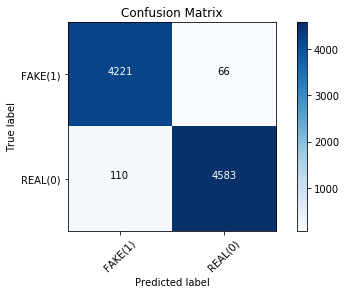

In [69]:
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])

## 5.3 SVM Modelling 

### 1.TFIDF

In [25]:
from sklearn.svm import SVC, LinearSVC

SVCPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LinearSVC())])

model = SVCPipeline.fit(xTrain, yTrain)
yPredict = model.predict(xTest)

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

Accuracy: 99.48%
Confusion Matrix 
 [[4267   20]
 [  27 4666]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4287
           1       1.00      0.99      0.99      4693

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Confusion matrix, without normalization


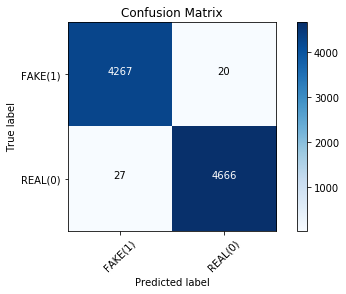

In [26]:
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])

### 2. N-gram 

In [27]:
model = LinearSVC()
LRModel = model.fit(xTrainNgram, yTrain)

yPredict = LRModel.predict(vect.transform(xTest))

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 97.87%
Confusion Matrix 
 [[4169  118]
 [  73 4620]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4287
           1       0.98      0.98      0.98      4693

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



Confusion matrix, without normalization


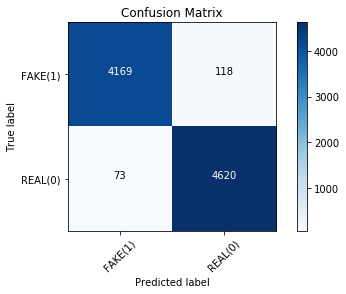

In [28]:
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])

### 5.4 Multinomial Naive Bayes

### 1.TFIDF

In [29]:
from sklearn.naive_bayes import MultinomialNB

NBPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())])

model = NBPipeline.fit(xTrain, yTrain)
yPredict = model.predict(xTest)

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

Accuracy: 93.55%
Confusion Matrix 
 [[3991  296]
 [ 283 4410]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4287
           1       0.94      0.94      0.94      4693

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



Confusion matrix, without normalization


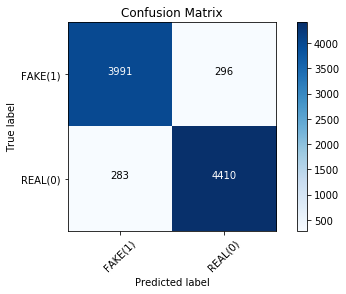

In [30]:
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])

### 2. N-gram 

In [31]:
model = MultinomialNB()
LRModel = model.fit(xTrainNgram, yTrain)

yPredict = LRModel.predict(vect.transform(xTest))

cm = confusion_matrix (yTest, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(yTest, yPredict)*100,2)))
print ("Confusion Matrix \n", cm)
print(classification_report(yTest, yPredict))

Accuracy: 96.5%
Confusion Matrix 
 [[4217   70]
 [ 244 4449]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4287
           1       0.98      0.95      0.97      4693

    accuracy                           0.97      8980
   macro avg       0.96      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



Confusion matrix, without normalization


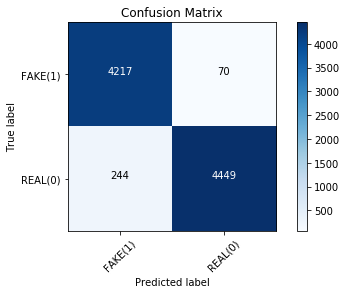

In [32]:
plot_confusion_matrix(cm,classes=['FAKE(1)','REAL(0)'])